In [1]:
import sys
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lens import profile
from ionization import ionization

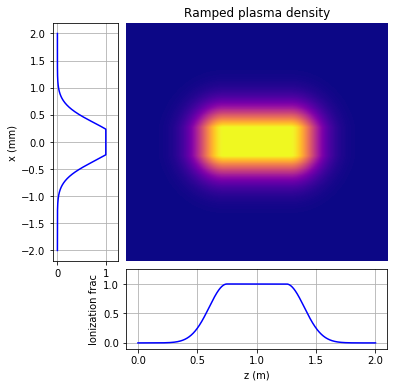

In [2]:
# Adiabatic ramp plot
z0 = 0.75e6
zf = 2e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 5000
d1 = 0.0
d2 = z0
d3 = z0 + dz
if zf is not 0:
    d4 = zf
else:
    d4 = d3+10*sigmaOut
Z = d4 - d1
z = np.linspace(d1, d1+Z, N)
# Create the density profile
frac = np.zeros(N)
peak = 1
sel = z <= d2
frac[sel] = peak*np.exp(-(z[sel]-d2)**2/(2*sigmaIn**2))
sel = np.array(z > d2) * np.array(z < d3)
frac[sel] = peak
sel = z >= d3
frac[sel] = peak*np.exp(-(z[sel]-d3)**2/(2*sigmaOut**2))

# Create the transverse intensity
Nx = 1000
x = np.linspace(-2, 2, Nx)
sigma = 0.25
tran = 1.25*np.exp(-x**2/.25)
sel = tran > 1.0
tran[sel] = 1.0

# Create the plasma density
den = np.reshape(frac, (1, N)) * np.reshape(tran, (Nx, 1))

plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 4], height_ratios=[3, 1], wspace=0.05, hspace=0.05)

plt.subplot(gs[0, 0])
plt.plot(tran, x, 'b')
plt.ylabel('x (mm)')
plt.xlim([-.1, 1.25])
plt.grid(True)

plt.subplot(gs[0, 1])
plt.imshow(den, aspect='auto', cmap='plasma')
plt.axis('off')
plt.title('Ramped plasma density')

plt.subplot(gs[1, 1])
plt.plot(z/1e6, frac, 'b')
plt.xlabel('z (m)')
plt.ylabel('Ionization frac')
plt.ylim([-.1, 1.25])
plt.grid(True)

plt.savefig('rampedPlasma.svg')
plt.show()

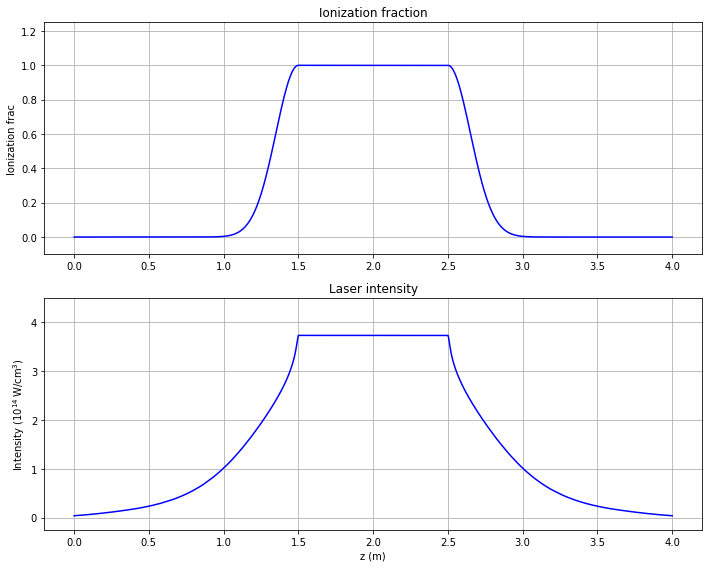

In [3]:
# Create the desired intensity profile
z0 = 1.5e6
zf = 4e6
dz = 1e6
d1 = 0.0
d2 = z0
d3 = z0 + dz
if zf is not 0:
    d4 = zf
else:
    d4 = d3+10*sigmaOut
Z = d4 - d1
z = np.linspace(d1, d1+Z, N)
# Create the density profile
frac = np.zeros(N)
peak = 1
sel = z <= d2
frac[sel] = peak*np.exp(-(z[sel]-d2)**2/(2*sigmaIn**2))
sel = np.array(z > d2) * np.array(z < d3)
frac[sel] = peak
sel = z >= d3
frac[sel] = peak*np.exp(-(z[sel]-d3)**2/(2*sigmaOut**2))
ion = {'atom' : ionization.Ar,
       'tau' : 35,
       'type' : 'gaussian'}
# Central intensity profile
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])#, wspace=0.05, hspace=0.05)

plt.subplot(gs[0, 0])
plt.plot(z/1e6, frac, 'b')
plt.ylabel('Ionization frac')
plt.ylim([-.1, 1.25])
plt.grid(True)
plt.title('Ionization fraction')

plt.subplot(gs[1, 0])
plt.plot(z/1e6, I, 'b')
plt.xlabel('z (m)')
plt.ylabel(r'Intensity ($10^{14}\,\mathrm{W/cm^3}$)')
plt.ylim([-.25, 4.5])
plt.grid(True)
plt.title('Laser intensity')

plt.tight_layout()
plt.savefig('IonizationAndIntensity.svg')
plt.show()

In [4]:
# Test if the generalized function works
from lens import bessel
from scipy.interpolate import interp1d
from propagation import laser
from scipy import integrate
import os
from propagation import propagation
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

params = {'N' : 1000,
          'M' : 1000,
          'R' : 0.1e3,
          'lam' : 0.8,
          'rmax' : 20e3
         }
Ez = ionization.field_from_intensity(I)
rm, E = bessel.uniform_bessel(params, Ez, z)

zFres = np.linspace(1e5, 4e6, 1000)
Efield = interp1d(rm, E)
r = np.linspace(0, 15e3, 10000)
E0 = Efield(r)

e = laser.fresnel_axis(E0, r, zFres, params['lam'])
IFres = ionization.intensity_from_field(abs(e))
Itot = integrate.simps(I, z)
Iact = integrate.simps(IFres, zFres)
IFres = IFres * (Itot/Iact)

# Initial electric field
def Efunc(x, y, params):
    r = np.sqrt(x**2 + y**2)
    Efield = params['Efield']
    E0 = Efield(r)
    return E0

# Setup the parameters
params = {'Nx' : 2**12,
          'Ny' : 2**8,
          'Nz' : 2**8,
          'Nt' : 2**6,
          'X' : 25e3,
          'Y' : 25e3,
          'Z' : 4e6,
          'n0' : 0.5,
          'E0' : 1.0,
          'lam' : 0.8,
          'n' : 1.0,
          'Efield' : Efield
          }

path = '/media/robert/Data_Storage/Data/Optics/Bessel/'

directory = '100um_Bessel'
params['path'] = directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
#propagation.laser_prop(params, Efunc)
#propagation.laser_prop_plot(params['path'])

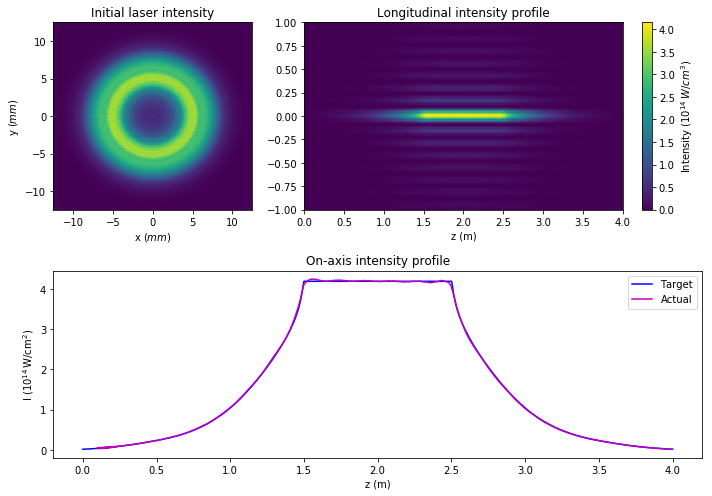

In [5]:
path = '/media/robert/Data_Storage/Data/Optics/Bessel/100um_Bessel/'
Eplot = np.load(path+'electricField.npy')
Ei = np.load(path+'inputField.npy')
params = np.load(path+'params.npy').item()
X = params['X']
Y = params['Y']
Ny = params['Ny']
def prep_data(data):
    return np.flipud(np.transpose(ionization.intensity_from_field(abs(data))))
sel = Eplot[0, :, :] > 2.75e-7
Eplot[0, sel] = 0.0

plt.figure(figsize={10, 7})
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 2])#, wspace=0.05, hspace=0.05)

plt.subplot(gs[0, 0])
plt.imshow(prep_data(Eplot[0, :, :]),
           aspect='auto',
           extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Initial laser intensity')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.subplot(gs[0, 1])
plt.imshow(prep_data(Eplot[:, :, int(Ny/2)])*0.65e14,
           aspect='auto',
           extent=[0, 4, -X/2e3, X/2e3])
plt.xlim([0, 4])
plt.ylim(-1, 1)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.xlabel('z (m)')
plt.title('Longitudinal intensity profile')

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.plot(z[0:4000]/1e6, I[0:4000], 'b-', zFres/1e6, IFres, 'm-')
plt.title('On-axis intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])

plt.tight_layout()
plt.savefig('SuperpositionOfBeam.svg')
plt.show()

In [36]:
# Bessel beam
# Test of a axicon lens
Nx = 2**10
X = 4000
x = np.linspace(-X/2, X/2, Nx, False)
Ny = 2**8
Y = X
y = np.linspace(-Y/2, Y/2, Ny, False)
# z after lens
Nz2 = 2**8
Z2 = 10
z0 = 0.125e6
z2 = np.linspace(z0, z0+Z2, Nz2)

w0 = 1e3
E0 = np.exp(-(np.reshape(x, (Nx, 1))**2 + np.reshape(y, (1, Ny))**2) / w0**2)

alpha = np.radians(0.5)
El = E0 * np.exp(-1j*np.pi*alpha*np.sqrt(np.reshape(x, (Nx, 1))**2 + np.reshape(y, (1, Ny))**2))
E = laser.fourier_prop2(El, x, y, z2, 1)

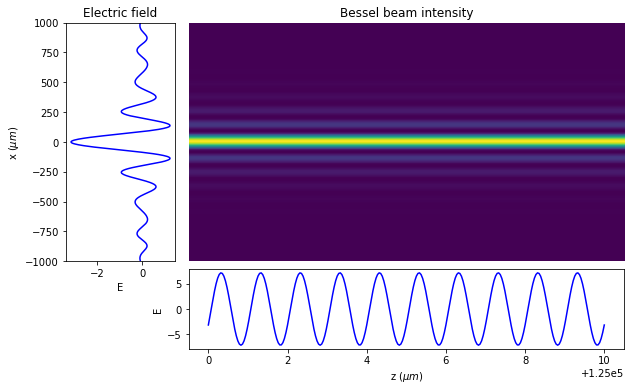

In [42]:
plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 4], height_ratios=[3, 1], wspace=0.05, hspace=0.05)

plt.subplot(gs[0, 0])
plt.plot(E[0, :, int(Ny/2)].real, x, 'b')
plt.ylim([-1e3, 1e3])
plt.title('Electric field')
plt.ylabel(r'x ($\mu m$)')
plt.xlabel('E')

plt.subplot(gs[0, 1])
plt.imshow(prep_data(E[:, :, int(Ny/2)]), aspect='auto', extent=[0, Z2, -X/2e3, X/2e3])
#cb = plt.colorbar()
#cb.set_label(r'Intensity (arb. units)')
plt.title('Bessel beam intensity')
plt.axis('off')
plt.ylim([-1, 1])

plt.subplot(gs[1, 1])
plt.plot(z2, E[:, int(Nx/2), int(Ny/2)].real, 'b')
#plt.ylim([-1e3, 1e3])
plt.xlabel(r'z ($\mu m$)')
plt.ylabel('E')

plt.savefig('BesselBeam.svg')
plt.show()